In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf
import os

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
## Get images from UTKFace at https://susanqq.github.io/UTKFace/
## In-the-wild version was used for these models
## Based on code found on https://github.com/serengil/tensorflow-101

#os.chdir(r'C:\Users\user\Downloads') # change it to the path that contains table(mat).csv
df = pd.read_csv('utk_uncropped_all/utkCrop_no16.csv', usecols=['age', 'gender', 'race', 'date&time', 'filename'])
df.dropna(inplace=True)

In [4]:
df.head()

,age,gender,race,date&time,filename
0,100,0.0,0,20170112213500903,100_0_0_20170112213500903.jpg
1,100,0.0,0,20170112215240346,100_0_0_20170112215240346.jpg
2,100,1.0,0,20170110183726390,100_1_0_20170110183726390.jpg
3,100,1.0,0,20170112213001988,100_1_0_20170112213001988.jpg
4,100,1.0,0,20170112213303693,100_1_0_20170112213303693.jpg


In [5]:
df = df.drop(columns = 'date&time')


In [6]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]

#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [7]:
df.head()

,age,gender,race,filename
0,100,0.0,0,100_0_0_20170112213500903.jpg
1,100,0.0,0,100_0_0_20170112215240346.jpg
2,100,1.0,0,100_1_0_20170110183726390.jpg
3,100,1.0,0,100_1_0_20170112213001988.jpg
4,100,1.0,0,100_1_0_20170112213303693.jpg


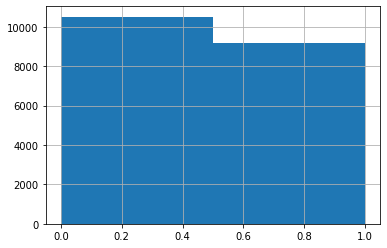

In [8]:
histogram = df['gender'].hist(bins=df['gender'].nunique())

In [9]:
df['gender'].value_counts().sort_index()
#0: woman, 1: man

0.0    10517
1.0     9197
Name: gender, dtype: int64

In [10]:
classes = 2 #man woman
print("number of output classes: ",classes)

number of output classes:  2


In [11]:
target_size = (224, 224)

def getImagePixels(image_path):
    img = image.load_img("utk_uncropped_all/%s" % image_path, grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [12]:
df['pixels'] = df['filename'].apply(getImagePixels)

In [13]:
df.head()

,age,gender,race,filename,pixels
0,100,0.0,0,100_0_0_20170112213500903.jpg,"[51.0, 55.0, 64.0, 82.0, 86.0, 95.0, 73.0, 77...."
1,100,0.0,0,100_0_0_20170112215240346.jpg,"[113.0, 117.0, 126.0, 113.0, 117.0, 126.0, 114..."
2,100,1.0,0,100_1_0_20170110183726390.jpg,"[226.0, 229.0, 236.0, 232.0, 235.0, 242.0, 227..."
3,100,1.0,0,100_1_0_20170112213001988.jpg,"[65.0, 72.0, 80.0, 65.0, 72.0, 80.0, 65.0, 72...."
4,100,1.0,0,100_1_0_20170112213303693.jpg,"[31.0, 36.0, 40.0, 31.0, 36.0, 40.0, 31.0, 36...."


In [14]:
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, classes)

In [15]:
#features = df['pixels'].values
features = []

for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [16]:
features.shape

(19714, 224, 224, 3)

In [17]:
features /= 255 #normalize in [0, 1]

In [18]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)

In [19]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('vgg_face_weights.h5')

In [ ]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs=model.input, outputs=base_model_output)

In [ ]:
#check trainable layers
#if False:
for layer in model.layers:
    print(layer, layer.trainable)

print("------------------------")
for layer in gender_model.layers:
    print(layer, layer.trainable)

In [ ]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']

                     , options=run_opts
                    )

In [ ]:
checkpointer = ModelCheckpoint(
    filepath='classification_gender_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [ ]:
scores = []

In [ ]:
enableFit = False

if enableFit:
    epochs = 250
    batch_size = 512

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = gender_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
        
        from keras.models import load_model
        gender_model = load_model("classification_gender_model.hdf5")
        
        gender_model.save_weights('gender_model_weights_utk.h5')
        
else:
    #pre-trained weights for gender prediction: https://drive.google.com/file/d/1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk/view?usp=sharing
    gender_model.load_weights("gender_model_weights_utk.h5")

In [ ]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

# Testing model on the testing set

In [ ]:
#loss and accuracy on validation set
gender_model.evaluate(test_x, test_y, verbose=1)

In [ ]:
predictions = gender_model.predict(test_x)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

pred_list = []; actual_list = []

for i in predictions:
    pred_list.append(np.argmax(i))

for i in test_y: 
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

# Testing model

Feed an image to find the gender

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [ ]:
picture = "Robbie.jpg" #replace by desired image to predict gender on

prediction = gender_model.predict(loadImage(picture))

In [ ]:
img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

gender = "Man" if np.argmax(prediction) == 1 else "Woman"

print("gender: ", gender)

# Test on UTK

In [ ]:

utk_info = pd.read_csv('utkCrop.csv', usecols=['age', 'gender', 'race', 'date&time', 'filename'])
utk_info.dropna(inplace=True)
pred_gender = []         
#os.chdir(r'C:\Users\user\Downloads\') # change it to where the corresponding pics locates
count=0
for file in utk_info['filename']:
    count+=1
    if count%1000 ==0:
        print(count)
    prediction = gender_model.predict(loadImage(file))
    pred_gender = np.argmax(prediction)
utk_info['pred_gender'] = pred_gender
utk_info;